## Preparing the dataset

Following the instructons you should have checked out the project and started jupyter notebook in the parent folder.
```
uni-sofia-entity-linking-magellan    <= "jupyter notebook" started here
 |- datasets
 |- notebooks
    |- entity_match_electronics.ipynb
```
 

In [1]:
# Extract the zip file with dataset CSV files (amazon.csv, best_buy.csv )
# -o is to overwrite
!unzip -o ../dataset/dataset_electronics_ID_8.zip -d ../dataset/ 

Archive:  ../dataset/dataset_electronics_ID_8.zip
  inflating: ../dataset/amazon.csv   
  inflating: ../dataset/best_buy.csv  


In [2]:
import zipfile
with zipfile.ZipFile("../dataset/dataset_electronics_ID_8.zip","r") as zip_ref:
    zip_ref.extractall("../dataset/")

In [3]:
# Import py_entitymatching package
import py_entitymatching as em
import os
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt

In [4]:
# Read the CSV files and set 'ID' as the key attribute
A = em.read_csv_metadata("../dataset/amazon.csv", key='ID')
B = em.read_csv_metadata("../dataset/best_buy.csv", key='ID')

Metadata file is not present in the given path; proceeding to read the csv file.
Metadata file is not present in the given path; proceeding to read the csv file.


Lets have a look at the loaded data frames. Notice that `A`.`Original_Price` can be null.

In [5]:
A.head(3)

,ID,Brand,Name,Amazon_Price,Original_Price,Features
0,1,Asus,"ASUS X205TA 11.6 Inch Laptop (Intel Atom, 2 GB, 32GB SSD, Gold) - Free Upgrade to Windows 10",$199.00,NaN,Intel Atom 1.33 GHz Processor. 2 GB DDR3 RAM. 32GB SSD Storage; No Optical Drive. 11.6 inches 13...
1,2,Other,AmazonBasics 11.6-Inch Laptop Sleeve,$9.99,NaN,Form-fitting sleeve with quick top-loading access for Chromebooks and MacBook Air laptops. Preci...
2,3,Lenovo,Lenovo G50 Entertainment Laptop - Black: DOORBUSTER - Intel Core i7-5500U (2.4GHz / 3.0 GHz Turb...,$799.77,$999.99,"5th Generation Intel Core i7-5500U Processor (2.4 GHz Turbo / 3.0 GHz Base, 1600MHz 4MB). 15.6\ ..."


In [6]:
B.head(3)

,ID,Brand,Name,Price,Description,Features
0,1,Asus,Asus 11.6 Laptop Intel Atom 2GB Memory 32GB Flash Storage Blue X205TA-SATM0404G,$189.99,"11.6&#34; Laptop - Intel Atom - 2GB Memory - 32GB Flash Storage, Read customer reviews and buy o...","Microsoft Windows 8.1 operating system preinstalled,Intel?? Atom??? processor Z3735F,2GB DDR3L m..."
1,2,HP,HP 15.6 TouchScreen Laptop Intel Core i3 6GB Memory 750GB Hard Drive Black 15-r264dx,$379.99,"15.6&#34; Touch-Screen Laptop - Intel Core i3 - 6GB Memory - 750GB Hard Drive, Read customer rev...","Microsoft Windows 8.1 operating system preinstalled,5th Gen Intel?? Core??? i3-5010U processor,I..."
2,3,Asus,Asus 2in1 13.3 TouchScreen Laptop Intel Core i5 6GB Memory 1TB Hard Drive Black Q302LA-BBI5T19,$749.99,"2-in-1 13.3&#34; Touch-Screen Laptop - Intel Core i5 - 6GB Memory - 1TB Hard Drive, Read custome...","Microsoft Windows 10 operating system,13.3 TFT-LCD touch screen for hands-on control,5th Gen Int..."


In [7]:
print(f"len(A): {len(A)}")
print(f"len(B): {len(B)}")
print(f"len(A) * len(B): {len(A) * len(B)}")

len(A): 4259
len(B): 5001
len(A) * len(B): 21299259


## Creating additional features is important
Here we will try to parse and make additional features

In [8]:
# Tokens with digits are important
# so we introduce new field that will contain only tokens with digits, which might be 
# monitor length, cpu, ram, etc.

import re
def filter_tokens_with_digits(s):
    s = str(s)
    s = re.sub('&#34;|[*\\\()\-\/]', ' ',s)
    s = re.sub(',', ' ',s)
    toks = s.split()
    toks = list(filter(lambda x: bool(re.search(r'\d', x)), toks))
    return ' '.join(toks)

def filter_toks_letters(s):
    s = str(s)
    toks = s.split()
    toks = list(filter(lambda x: bool(re.search(r'[a-zA-Z]', x)), toks))
    return ' '.join(toks)

# Example
print(filter_tokens_with_digits('2-in-1 13.3&#34; Touch,-Screen Laptop - Intel Core i5 - 6GB Memory - 1TB Hard Drive, Read'))
print(filter_toks_letters(filter_tokens_with_digits('2-in-1 13.3&#34; Touch,-Screen Laptop - Intel Core i5 - 6GB Memory - 1TB Hard Drive, Read')))

2 1 13.3 i5 6GB 1TB
i5 6GB 1TB


In [9]:
A['Parameters'] = A['Name'] + " " + A['Features']
A['Parameters'] = A['Parameters'].apply(filter_tokens_with_digits)
A.head(3)

,ID,Brand,Name,Amazon_Price,Original_Price,Features,Parameters
0,1,Asus,"ASUS X205TA 11.6 Inch Laptop (Intel Atom, 2 GB, 32GB SSD, Gold) - Free Upgrade to Windows 10",$199.00,NaN,Intel Atom 1.33 GHz Processor. 2 GB DDR3 RAM. 32GB SSD Storage; No Optical Drive. 11.6 inches 13...,X205TA 11.6 2 32GB 10 1.33 2 DDR3 32GB 11.6 1366 768 8.1
1,2,Other,AmazonBasics 11.6-Inch Laptop Sleeve,$9.99,NaN,Form-fitting sleeve with quick top-loading access for Chromebooks and MacBook Air laptops. Preci...,11.6 11.6 11.4 0.4 8.4 12.2 0.8 9
2,3,Lenovo,Lenovo G50 Entertainment Laptop - Black: DOORBUSTER - Intel Core i7-5500U (2.4GHz / 3.0 GHz Turb...,$799.77,$999.99,"5th Generation Intel Core i7-5500U Processor (2.4 GHz Turbo / 3.0 GHz Base, 1600MHz 4MB). 15.6\ ...",G50 i7 5500U 2.4GHz 3.0 8GB 1TB 15.6 1080P USB3.0 8.1 5th i7 5500U 2.4 3.0 1600MHz 4MB 15.6 1080...


<AxesSubplot:>

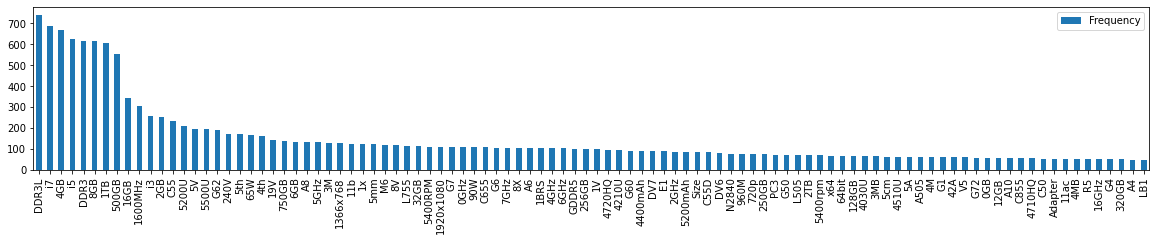

In [36]:
aParams =" ".join(A['Parameters'].tolist())
tokenizer = RegexpTokenizer(r'\w+')
a = list(filter(lambda x: x.isdecimal() is False , tokenizer.tokenize(aParams))) 
aDist = FreqDist(a)
df_aDist = pd.DataFrame.from_dict(aDist, orient='index')
df_aDist.columns =['Frequency']
df_aDist = df_aDist.sort_values('Frequency', ascending=[False])

df_aDist[0:100].plot(kind = 'bar', figsize = (20, 3))


In [13]:
B['Parameters'] = B['Name'] + " " + B['Description']+ " " + B['Features']
B['Parameters'] = B['Parameters'].apply(filter_tokens_with_digits)
B.head(3)

,ID,Brand,Name,Price,Description,Features,Parameters
0,1,Asus,Asus 11.6 Laptop Intel Atom 2GB Memory 32GB Flash Storage Blue X205TA-SATM0404G,$189.99,"11.6&#34; Laptop - Intel Atom - 2GB Memory - 32GB Flash Storage, Read customer reviews and buy o...","Microsoft Windows 8.1 operating system preinstalled,Intel?? Atom??? processor Z3735F,2GB DDR3L m...",11.6 2GB 32GB X205TA SATM0404G 11.6 2GB 32GB 8.1 Z3735F 2GB DDR3L 11.6 32GB 0.3MP 2 2.0 802.11a ...
1,2,HP,HP 15.6 TouchScreen Laptop Intel Core i3 6GB Memory 750GB Hard Drive Black 15-r264dx,$379.99,"15.6&#34; Touch-Screen Laptop - Intel Core i3 - 6GB Memory - 750GB Hard Drive, Read customer rev...","Microsoft Windows 8.1 operating system preinstalled,5th Gen Intel?? Core??? i3-5010U processor,I...",15.6 i3 6GB 750GB 15 r264dx 15.6 i3 6GB 750GB 8.1 5th i3 5010U i3 6GB DDR3L 15.6 750GB 7200 5500...
2,3,Asus,Asus 2in1 13.3 TouchScreen Laptop Intel Core i5 6GB Memory 1TB Hard Drive Black Q302LA-BBI5T19,$749.99,"2-in-1 13.3&#34; Touch-Screen Laptop - Intel Core i5 - 6GB Memory - 1TB Hard Drive, Read custome...","Microsoft Windows 10 operating system,13.3 TFT-LCD touch screen for hands-on control,5th Gen Int...",2in1 13.3 i5 6GB 1TB Q302LA BBI5T19 2 1 13.3 i5 6GB 1TB 10 13.3 5th i5 5200U 6GB 1TB 3.75 0.87 2...


<AxesSubplot:>

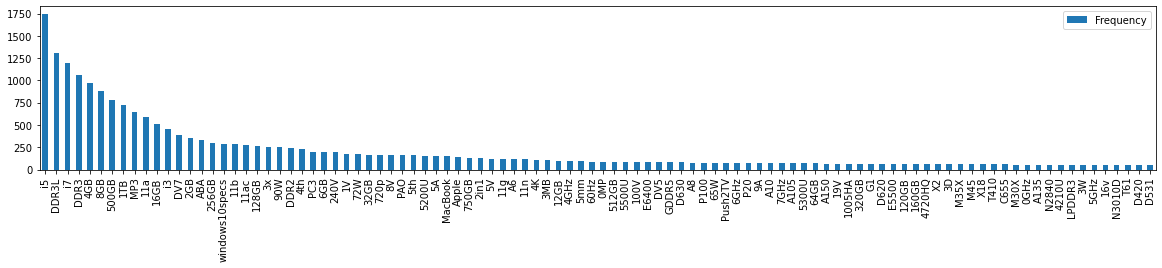

In [35]:
bParams =" ".join(B['Parameters'].tolist())
tokenizer = RegexpTokenizer(r'\w+')
b = list(filter(lambda x: x.isdecimal() is False , tokenizer.tokenize(bParams))) 
bDist = FreqDist(b)
df_bDist = pd.DataFrame.from_dict(bDist, orient='index')
df_bDist.columns =['Frequency']
df_bDist = df_bDist.sort_values('Frequency', ascending=[False])

df_bDist[0:100].plot(kind = 'bar', figsize = (20, 3))

# Extract terms based on tfidf score

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
tf = TfidfVectorizer(input='content', analyzer='word', ngram_range=(1,1),
                      min_df = 0, stop_words = 'english', sublinear_tf=True)

In [15]:
# Fit A and B to be one big corpus of terms
tf.fit((A['Brand'] + ' ' + A['Name']).fillna(""))
tf.fit((B['Brand'] + ' ' + B['Name']).fillna(""))

TfidfVectorizer(min_df=0, stop_words='english', sublinear_tf=True)

In [16]:
# TFIDF for set A
tfidf_matrix =  tf.transform((A['Brand'] + ' ' + A['Name']).fillna(""))
feature_array = np.array(tf.get_feature_names())
def extract_top_tfidf(column):
     response = tf.transform([column])
     tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
     n = 5
     top_n = feature_array[tfidf_sorting][:n]
     # stringify
     return " ".join(top_n)
A['tfidf'] = ((A['Brand'] + ' ' + A['Name']).fillna("")).apply(extract_top_tfidf)

In [17]:
# TFIDF for set B
tfidf_matrix =  tf.transform((B['Brand'] + ' ' + B['Name']).fillna(""))
feature_array = np.array(tf.get_feature_names())
def extract_top_tfidf(column):
     response = tf.transform([column])
     tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
     n = 5
     top_n = feature_array[tfidf_sorting][:n]
     # stringify
     return " ".join(top_n)
B['tfidf'] = ((B['Brand'] + ' ' +B['Name']).fillna("")).apply(extract_top_tfidf)

In [18]:
A.head(2)

,ID,Brand,Name,Amazon_Price,Original_Price,Features,Parameters,tfidf
0,1,Asus,"ASUS X205TA 11.6 Inch Laptop (Intel Atom, 2 GB, 32GB SSD, Gold) - Free Upgrade to Windows 10",$199.00,NaN,Intel Atom 1.33 GHz Processor. 2 GB DDR3 RAM. 32GB SSD Storage; No Optical Drive. 11.6 inches 13...,X205TA 11.6 2 32GB 10 1.33 2 DDR3 32GB 11.6 1366 768 8.1,inch upgrade x205ta asus ssd
1,2,Other,AmazonBasics 11.6-Inch Laptop Sleeve,$9.99,NaN,Form-fitting sleeve with quick top-loading access for Chromebooks and MacBook Air laptops. Preci...,11.6 11.6 11.4 0.4 8.4 12.2 0.8 9,inch sleeve 11 laptop zseries


In [19]:
B.head(2)

,ID,Brand,Name,Price,Description,Features,Parameters,tfidf
0,1,Asus,Asus 11.6 Laptop Intel Atom 2GB Memory 32GB Flash Storage Blue X205TA-SATM0404G,$189.99,"11.6&#34; Laptop - Intel Atom - 2GB Memory - 32GB Flash Storage, Read customer reviews and buy o...","Microsoft Windows 8.1 operating system preinstalled,Intel?? Atom??? processor Z3735F,2GB DDR3L m...",11.6 2GB 32GB X205TA SATM0404G 11.6 2GB 32GB 8.1 Z3735F 2GB DDR3L 11.6 32GB 0.3MP 2 2.0 802.11a ...,satm0404g x205ta asus atom storage
1,2,HP,HP 15.6 TouchScreen Laptop Intel Core i3 6GB Memory 750GB Hard Drive Black 15-r264dx,$379.99,"15.6&#34; Touch-Screen Laptop - Intel Core i3 - 6GB Memory - 750GB Hard Drive, Read customer rev...","Microsoft Windows 8.1 operating system preinstalled,5th Gen Intel?? Core??? i3-5010U processor,I...",15.6 i3 6GB 750GB 15 r264dx 15.6 i3 6GB 750GB 8.1 5th i3 5010U i3 6GB DDR3L 15.6 750GB 7200 5500...,r264dx 750gb hp 6gb i3


## Persist A and B with new features to be available for the matching


In [20]:
# Read the CSV files and set 'ID' as the key attribute
em.to_csv_metadata(A, file_path="../dataset/amazon_new_features.csv")
em.to_csv_metadata(B, file_path="../dataset/best_buy_new_features.csv")

File already exists at ../dataset/amazon_new_features.csv; Overwriting it
Metadata file already exists at ../dataset/amazon_new_features.metadata. Overwriting it
File already exists at ../dataset/best_buy_new_features.csv; Overwriting it
Metadata file already exists at ../dataset/best_buy_new_features.metadata. Overwriting it


True

# Block Tables and Make Set of Candidates

Obviously having 21'299'259 records as a cross product between `A` and `B` is quite high value. What we are going to do now is to reduce obviously non-matching pairs. This process is called blocking tables `A` and `B`. We can use 2 of the blocking mechanisms provided by *py_entitymatching* and namely that would be:
 - attribute equivalence
 - overlap
We know that for an electronics to match , it should be the same `Brand`, so this should match. Sometimes it can have error or typo in the brand, so we can use overlap for tokens in the `Name` and `Description`. Here is the blocking plan:

In [21]:
# Blocking plan

# A, B -- AttrEquivalence blocker [Brand]--|
#                                        |---Overlap[Parameters]-Overlap[tfidf]--> candidate set
# A, B -- Overlap blocker [Name]-----------|

In [22]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C1 = ab.block_tables(A, B, 'Brand', 'Brand', 
                     l_output_attrs=['Brand','Name','Amazon_Price','Original_Price','Features','Parameters','tfidf'],
                     r_output_attrs=['Brand','Name','Price','Description','Features','Parameters','tfidf']
                    )
len(C1)

4439971

In [23]:
C1.head(2)

,_id,ltable_ID,rtable_ID,ltable_Brand,ltable_Name,ltable_Amazon_Price,ltable_Original_Price,ltable_Features,ltable_Parameters,ltable_tfidf,rtable_Brand,rtable_Name,rtable_Price,rtable_Description,rtable_Features,rtable_Parameters,rtable_tfidf
0,0,1,1,Asus,"ASUS X205TA 11.6 Inch Laptop (Intel Atom, 2 GB, 32GB SSD, Gold) - Free Upgrade to Windows 10",$199.00,NaN,Intel Atom 1.33 GHz Processor. 2 GB DDR3 RAM. 32GB SSD Storage; No Optical Drive. 11.6 inches 13...,X205TA 11.6 2 32GB 10 1.33 2 DDR3 32GB 11.6 1366 768 8.1,inch upgrade x205ta asus ssd,Asus,Asus 11.6 Laptop Intel Atom 2GB Memory 32GB Flash Storage Blue X205TA-SATM0404G,$189.99,"11.6&#34; Laptop - Intel Atom - 2GB Memory - 32GB Flash Storage, Read customer reviews and buy o...","Microsoft Windows 8.1 operating system preinstalled,Intel?? Atom??? processor Z3735F,2GB DDR3L m...",11.6 2GB 32GB X205TA SATM0404G 11.6 2GB 32GB 8.1 Z3735F 2GB DDR3L 11.6 32GB 0.3MP 2 2.0 802.11a ...,satm0404g x205ta asus atom storage
1,1,1,3,Asus,"ASUS X205TA 11.6 Inch Laptop (Intel Atom, 2 GB, 32GB SSD, Gold) - Free Upgrade to Windows 10",$199.00,NaN,Intel Atom 1.33 GHz Processor. 2 GB DDR3 RAM. 32GB SSD Storage; No Optical Drive. 11.6 inches 13...,X205TA 11.6 2 32GB 10 1.33 2 DDR3 32GB 11.6 1366 768 8.1,inch upgrade x205ta asus ssd,Asus,Asus 2in1 13.3 TouchScreen Laptop Intel Core i5 6GB Memory 1TB Hard Drive Black Q302LA-BBI5T19,$749.99,"2-in-1 13.3&#34; Touch-Screen Laptop - Intel Core i5 - 6GB Memory - 1TB Hard Drive, Read custome...","Microsoft Windows 10 operating system,13.3 TFT-LCD touch screen for hands-on control,5th Gen Int...",2in1 13.3 i5 6GB 1TB Q302LA BBI5T19 2 1 13.3 i5 6GB 1TB 10 13.3 5th i5 5200U 6GB 1TB 3.75 0.87 2...,bbi5t19 q302la asus 6gb 2in1


In [24]:
# Initialize overlap blocker
ob = em.OverlapBlocker()
# Block over title attribute
C2 = ob.block_tables(A, B, 'Name', 'Name', show_progress=True, overlap_size=2)
len(C2)

/home/bobi/anaconda3/lib/python3.9/site-packages/py_entitymatching/blocker/overlap_blocker.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l_df[l_dummy_overlap_attr] = l_df[l_overlap_attr]
/home/bobi/anaconda3/lib/python3.9/site-packages/py_entitymatching/blocker/overlap_blocker.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_df[r_dummy_overlap_attr] = r_df[r_overlap_attr]
/home/bobi/anaconda3/lib/python3.9/site-packages/py_entitymatching/blocker/overlap_blocker.py:615: SettingWithCopyWarning:

3253258

In [25]:
# Combine the outputs from attr. equivalence blocker and overlap blocker
C = em.combine_blocker_outputs_via_union([C1, C2])
len(C)

6855987

### Narrow blocking
Still 3253258 is quite big number, so we will try to block again and narrow the candidate set.


In [26]:
# http://anhaidgroup.github.io/py_entitymatching/v0.1.x/user_manual/create_feats_for_blocking.html#label-create-features-blocking

D = ob.block_candset(C, l_overlap_attr='Parameters', r_overlap_attr='Parameters', \
                     word_level=True,overlap_size=1, \
                     allow_missing=True, n_jobs=1, \
                     show_progress=True)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:42


In [27]:
print(f"len(D) = {len(D)}")
D.head(2)

len(D) = 2769145


,_id,ltable_ID,rtable_ID,ltable_Brand,ltable_Name,ltable_Amazon_Price,ltable_Original_Price,ltable_Features,ltable_Parameters,ltable_tfidf,rtable_Brand,rtable_Name,rtable_Price,rtable_Description,rtable_Features,rtable_Parameters,rtable_tfidf
0,0,1,1,Asus,"ASUS X205TA 11.6 Inch Laptop (Intel Atom, 2 GB, 32GB SSD, Gold) - Free Upgrade to Windows 10",$199.00,NaN,Intel Atom 1.33 GHz Processor. 2 GB DDR3 RAM. 32GB SSD Storage; No Optical Drive. 11.6 inches 13...,X205TA 11.6 2 32GB 10 1.33 2 DDR3 32GB 11.6 1366 768 8.1,inch upgrade x205ta asus ssd,Asus,Asus 11.6 Laptop Intel Atom 2GB Memory 32GB Flash Storage Blue X205TA-SATM0404G,$189.99,"11.6&#34; Laptop - Intel Atom - 2GB Memory - 32GB Flash Storage, Read customer reviews and buy o...","Microsoft Windows 8.1 operating system preinstalled,Intel?? Atom??? processor Z3735F,2GB DDR3L m...",11.6 2GB 32GB X205TA SATM0404G 11.6 2GB 32GB 8.1 Z3735F 2GB DDR3L 11.6 32GB 0.3MP 2 2.0 802.11a ...,satm0404g x205ta asus atom storage
1,1,1,2,Asus,"ASUS X205TA 11.6 Inch Laptop (Intel Atom, 2 GB, 32GB SSD, Gold) - Free Upgrade to Windows 10",$199.00,NaN,Intel Atom 1.33 GHz Processor. 2 GB DDR3 RAM. 32GB SSD Storage; No Optical Drive. 11.6 inches 13...,X205TA 11.6 2 32GB 10 1.33 2 DDR3 32GB 11.6 1366 768 8.1,inch upgrade x205ta asus ssd,HP,HP 15.6 TouchScreen Laptop Intel Core i3 6GB Memory 750GB Hard Drive Black 15-r264dx,$379.99,"15.6&#34; Touch-Screen Laptop - Intel Core i3 - 6GB Memory - 750GB Hard Drive, Read customer rev...","Microsoft Windows 8.1 operating system preinstalled,5th Gen Intel?? Core??? i3-5010U processor,I...",15.6 i3 6GB 750GB 15 r264dx 15.6 i3 6GB 750GB 8.1 5th i3 5010U i3 6GB DDR3L 15.6 750GB 7200 5500...,r264dx 750gb hp 6gb i3


In [28]:
# http://anhaidgroup.github.io/py_entitymatching/v0.1.x/user_manual/create_feats_for_blocking.html#label-create-features-blocking

E = ob.block_candset(D, l_overlap_attr='tfidf', r_overlap_attr='tfidf', \
                     word_level=True,overlap_size=1, \
                     allow_missing=True, n_jobs=1, \
                     show_progress=True)

/home/bobi/anaconda3/lib/python3.9/site-packages/py_entitymatching/blocker/overlap_blocker.py:615: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table[overlap_attr] = values
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29


In [38]:
print(f"len(E) = {len(E)}")
E.to_csv('../dataset/all_candidates.csv')
E.head(2)

len(E) = 282581


_id  ltable_ID  rtable_ID ltable_Brand  \
0    0          1          1         Asus   
2    2          1          3         Asus   

                                                                                    ltable_Name  \
0  ASUS X205TA 11.6 Inch Laptop (Intel Atom, 2 GB, 32GB SSD, Gold) - Free Upgrade to Windows 10   
2  ASUS X205TA 11.6 Inch Laptop (Intel Atom, 2 GB, 32GB SSD, Gold) - Free Upgrade to Windows 10   

  ltable_Amazon_Price ltable_Original_Price  \
0             $199.00                   NaN   
2             $199.00                   NaN   

                                                                                       ltable_Features  \
0  Intel Atom 1.33 GHz Processor. 2 GB DDR3 RAM. 32GB SSD Storage; No Optical Drive. 11.6 inches 13...   
2  Intel Atom 1.33 GHz Processor. 2 GB DDR3 RAM. 32GB SSD Storage; No Optical Drive. 11.6 inches 13...   

                                          ltable_Parameters  \
0  X205TA 11.6 2 32GB 10 1.33 2 DDR3 32GB 11.6 1366 768 8.1   
2  X205TA 11.6 2 32GB 10 1.33 2 DDR3 32GB 11.6 1366 768 8.1   

                   ltable_tfidf rtable_Brand  \
0  inch upgrade x205ta asus ssd         Asus   
2  inch upgrade x205ta asus ssd         Asus   

                                                                                       rtable_Name  \
0                 Asus 11.6 Laptop Intel Atom 2GB Memory 32GB Flash Storage Blue X205TA-SATM0404G    
2  Asus 2in1 13.3 TouchScreen Laptop Intel Core i5 6GB Memory 1TB Hard Drive Black Q302LA-BBI5T19    

  rtable_Price  \
0      $189.99   
2      $749.99   

                                                                                    rtable_Description  \
0  11.6&#34; Laptop - Intel Atom - 2GB Memory - 32GB Flash Storage, Read customer reviews and buy o...   
2  2-in-1 13.3&#34; Touch-Screen Laptop - Intel Core i5 - 6GB Memory - 1TB Hard Drive, Read custome...   

                                                                                       rtable_Features  \
0  Microsoft Windows 8.1 operating system preinstalled,Intel?? Atom??? processor Z3735F,2GB DDR3L m...   
2  Microsoft Windows 10 operating system,13.3 TFT-LCD touch screen for hands-on control,5th Gen Int...   

                                                                                     rtable_Parameters  \
0  11.6 2GB 32GB X205TA SATM0404G 11.6 2GB 32GB 8.1 Z3735F 2GB DDR3L 11.6 32GB 0.3MP 2 2.0 802.11a ...   
2  2in1 13.3 i5 6GB 1TB Q302LA BBI5T19 2 1 13.3 i5 6GB 1TB 10 13.3 5th i5 5200U 6GB 1TB 3.75 0.87 2...   

                                  rtable_tfidf  label  
0           satm0404g x205ta asus atom storage      0  
2                 bbi5t19 q302la asus 6gb 2in1      0  
15       ux303uadh51t asus zenbook brown 256gb      0  
17        ux303ubdh74t asus zenbook 512gb 12gb      0  
21          ux305cadhm4t m3 asus zenbook 256gb      0  
...                                        ...    ...  
6855903   a2567 smartshell apple purple retina      0  
6855943      a1886 apple orange seethru retina      0  
6855944         a1892 apple seethru retina spk      0  
6855964        a2731 apple seethru pink retina      0  
6855965         a3305 apple seethru retina spk      0  

[282581 rows x 18 columns]

In [30]:
# Sample  candidate set
S = em.sample_table(E, 500)


In [31]:
S['label'] = 0

# We save this to manually label offline
S.to_csv('../dataset/sample_blocked_500.csv')

C:\Users\Kiril\AppData\Local\Temp\ipykernel_9468\620512548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S['label'] = 0


## Manually label data
Here we must go and manually label the data, but you can use the previously stored file.
In another jupyter notebook we continue from a labeled data from file `sample_blocked_500_labeled.csv`

In [31]:
S.head(1)

,_id,ltable_ID,rtable_ID,ltable_Brand,ltable_Name,ltable_Amazon_Price,ltable_Original_Price,ltable_Features,ltable_Parameters,ltable_tfidf,rtable_Brand,rtable_Name,rtable_Price,rtable_Description,rtable_Features,rtable_Parameters,rtable_tfidf,label
6854,6854,7,1621,Dell,"Dell Inspiron 11.6-Inch 2 in 1 Convertible Touchscreen Laptop, i3147-3750sLV",$371.14,$449.99,Intel Pentium Processor N3520 2.16GHz. 4 GB DDR3L SDRAM. 500 GB 7200 rpm Hard Drive. 11.6-Inch S...,11.6 2 1 i3147 3750sLV N3520 2.16GHz. 4 DDR3L 500 7200 11.6 8.1; 10,convertible inch dell inspiron 11,Dell,Dell 14 Latitude Notebook 4 GB Memory 500 GB Hard Drive Black E5450,$968.99,"14 Latitude Notebook - 4 GB Memory - 500 GB Hard Drive, Read customer reviews and buy online at ...","Processor Manufacturer: Intel,Processor Type: Core i5,Processor Model: i5-5300U,Processor Speed:...",14 4 500 E5450 14 4 500 i5 i5 5300U 2.30 2 4 DDR3L 500 14 16:9 1366 768 5500 DDR3L 802.11ac 3 3....,e5450 dell gb 500 latitude,0
6912,6912,7,1844,Dell,"Dell Inspiron 11.6-Inch 2 in 1 Convertible Touchscreen Laptop, i3147-3750sLV",$371.14,$449.99,Intel Pentium Processor N3520 2.16GHz. 4 GB DDR3L SDRAM. 500 GB 7200 rpm Hard Drive. 11.6-Inch S...,11.6 2 1 i3147 3750sLV N3520 2.16GHz. 4 DDR3L 500 7200 11.6 8.1; 10,convertible inch dell inspiron 11,Dell,Dell 15.6 Inspiron Notebook 6 GB Memory 500 GB Hard Drive Black I15RV1334BLK,$400.97,"15.6 Inspiron Notebook - 6 GB Memory - 500 GB Hard Drive, Read customer reviews and buy online a...","Processor Manufacturer: Intel,Processor Type: Core i3,Processor Model: i3-4010U,Processor Speed:...",15.6 6 500 I15RV1334BLK 15.6 6 500 i3 i3 4010U 1.70 2 6 DDR3 500 15.6 16:9 1366 768 4400 DDR3 80...,i15rv1334blk dell inspiron gb 500,0
7019,7019,7,2066,Dell,"Dell Inspiron 11.6-Inch 2 in 1 Convertible Touchscreen Laptop, i3147-3750sLV",$371.14,$449.99,Intel Pentium Processor N3520 2.16GHz. 4 GB DDR3L SDRAM. 500 GB 7200 rpm Hard Drive. 11.6-Inch S...,11.6 2 1 i3147 3750sLV N3520 2.16GHz. 4 DDR3L 500 7200 11.6 8.1; 10,convertible inch dell inspiron 11,Dell,Dell 14.1 Latitude Notebook 4 GB Memory 320 GB Hard Drive Black E5410,$220.99,"14.1 Latitude Notebook - 4 GB Memory - 320 GB Hard Drive, Read customer reviews and buy online a...","Processor Manufacturer: Intel,Processor Type: Core i3,Processor Speed: 2.27 GHz,Standard Memory:...",14.1 4 320 E5410 14.1 4 320 i3 2.27 4 DDR3 320 14.1 16:9 1366 768 DDR3 802.11n 4 45 7 64,e5410 320 dell gb latitude,0
10664,10664,10,2842,Asus,AC Adapter/Battery Charger for Asus Laptops,$8.08,NaN,DC-Output : 19V-4.74A-90W - Input : 100-240V - 1.5A 50/60 Hz. Package Includes : One AC Adapter ...,19V 4.74A 90W 100 240V 1.5A 50 60 100% 12,asus charger ac adapter battery,Dell,DENAQ AC Power Adapter and Charger for Select Dell Laptops Black DQ-PA-10-7450,$22.93,"AC Power Adapter and Charger for Select Dell Laptops, Read customer reviews and buy online at Be...","Compatible with select Dell laptops,Charges your compatible device,Safety fuses,Smart technology...",10 7450 13R 14R 15R 17R 600M 1150 1420 1501 1521 1720 1721 6400 8500 8600 9200 9300 9400 E1505 E...,pa 7450 10 dq charger,0
15372,15372,12,1979,Asus,"ASUS Zenbook UX305LA 13.3-Inch Laptop (Intel Core i5, 8GB, 256 GB SSD, Titanium Gold) with Windo...",$749.99,$849.99,13.3-Inch Full-HD IPS Anti-Glare Matte Display with an Ultra-wide 170�� Viewing Angle.. Powerful...,UX305LA 13.3 i5 8GB 256 10 13.3 170�� 5th i5 5200U 2.2GHz 2.7GHz 8 256 10 1.2 802.11ac. 3x 802.1...,inch asus zenbook ssd gold,Asus,ASUS Computer International K55ARBR6,$491.49,"Asus Refurbished - 15.6 Notebook - 6 GB Memory - 750 GB Hard Drive - Matte Brown, K55A-RBR6. Rea...","Processor Manufacturer: Intel,Processor Type: Core i5,Processor Model: i5-2450M,Processor Speed:...",K55ARBR6 15.6 6 750 K55A RBR6. i5 i5 2450M 2.50 2 3 64 6 8 DDR3 750 15.6 16:9 1366 768 802.11b 3...,k55arbr6 asus computer international blue,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6798839,6798839,4214,1935,Del